In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def print_data(*data):
    for d in data:
        print(f'Min: {d.min()}, Max: {d.max()}, shape: {d.shape}, dtype: {d.dtype}')

In [3]:
z = 0.1
X = np.expand_dims(np.arange(-10, 10, 0.1), axis=-1)
y = np.sin(X) + np.random.randn(*X.shape) * z

In [4]:
print_data(X, y)

Min: -10.0, Max: 9.899999999999928, shape: (200, 1), dtype: float64
Min: -1.2149670797627226, Max: 1.1546489308119936, shape: (200, 1), dtype: float64


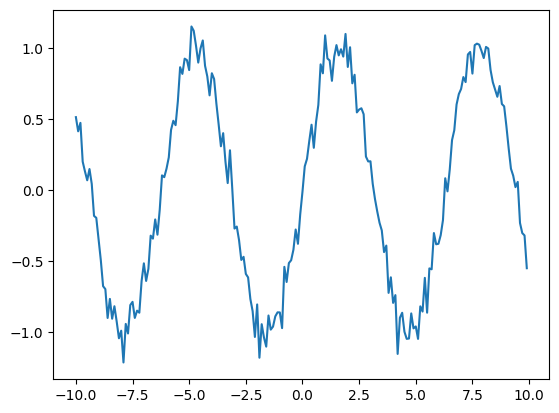

In [5]:
plt.plot(X, y)
plt.show()

In [6]:
def tanh(x, derv=False):
    if derv: return 1 - np.tanh(x)**2
    return np.tanh(x)

In [7]:
def derv_tanh(x):
    return 1 - x**2

In [8]:
def MSE(y, y_pred, derv=False):
    if derv: return 2*(y_pred-y)
    return np.mean((y_pred-y)**2)

In [9]:
INPUT_SIZE = 1
HIDDEN_SIZE = 50
OUTPUT_SIZE = 1

In [10]:
Wx = np.random.randn(INPUT_SIZE, HIDDEN_SIZE) * np.sqrt(2/(INPUT_SIZE+HIDDEN_SIZE))
Wh = np.random.randn(HIDDEN_SIZE, HIDDEN_SIZE) * np.sqrt(1/HIDDEN_SIZE)
Wy = np.random.randn(HIDDEN_SIZE, OUTPUT_SIZE) * np.sqrt(2/HIDDEN_SIZE)


bh = np.zeros((1, HIDDEN_SIZE))
by = np.zeros((1, OUTPUT_SIZE))

params = [Wy, by, Wh, Wx, bh]
len_params = len(params)

In [11]:
def update_params(grads, lr):
    for i in range(len_params):
        params[i] -= lr * grads[i]

In [12]:
def forward_cell(xt, h_prev):
    ht = tanh(xt @ Wx + h_prev @ Wh + bh)
    return ht

In [13]:
def forward(x):
    T = x.shape[0]

    H = np.zeros((T+1, 1, HIDDEN_SIZE))
    Y = np.zeros((T, OUTPUT_SIZE))

    for t in range(T):
        xt = np.expand_dims(x[t], axis=-1)
        H[t+1] = forward_cell(xt, H[t])
        
        Y[t] = H[t+1] @ Wy + by

    return Y, H

In [14]:
def backward_cell(dL, xt, ht, h_prev):
    dL *= derv_tanh(ht)

    dbh = dL.sum(axis=0, keepdims=True)

    dWx = xt.T @ dL
    dWh = h_prev.T @ dL

    dh_t = dL @ Wh.T
    dxt = dL @ Wx.T

    return dWx, dWh, dbh, dh_t, dxt

In [15]:
def backward(x, y_true, y_pred, H, learn=True, lr=0.001):
    T = x.shape[0]

    dWx = np.zeros_like(Wx)
    dWh = np.zeros_like(Wh)
    dWy = np.zeros_like(Wy)
    dbh = np.zeros_like(bh)
    dby = np.zeros_like(by)

    dh_next = np.zeros((1, HIDDEN_SIZE))
    dx = np.zeros_like(x)

    for t in reversed(range(T)):
        xt = x[t:t+1]
        yt = y_true[t:t+1]
        outp = y_pred[t:t+1]
        h_prev = H[t]
        ht = H[t+1]

        dL = MSE(yt, outp, derv=True)

        dWy += ht.T @ dL
        dby += dL.sum(axis=0, keepdims=True)

        dL = dL @ Wy.T + dh_next

        dWxt, dWht, dbht, dh_t, dx[t] = backward_cell(dL, xt, ht, h_prev)


        dh_next = dh_t

        dWx += dWxt
        dWh += dWht
        dbh += dbht

    dWx /= T
    dWh /= T
    dWy /= T
    dbh /= T
    dby /= T

    if learn:
        update_params((dWy, dby, dWh, dWx, dbh), lr)
    

In [16]:
def train(x, y, epochs=100, batch_size=8, lr=0.001, print_every=0.1):
    losses = []
    for epoch in range(1, epochs+1):
        for batch in range(0, x.shape[0], batch_size):
            x_batch = x[batch:batch+batch_size]
            y_batch = y[batch:batch+batch_size]
            y_pred, H = forward(x_batch)

            backward(x_batch, y_batch, y_pred, H, learn=True, lr=lr)
        
        loss = MSE(y, forward(x)[0])
        losses.append(loss)
        if epoch % max(1, int(epochs*print_every)) == 0:
            print(f'Epoch: [{epoch}/{epochs}]> Loss: {loss}')
    return losses

In [17]:
history_loss = train(x=X, y=y, epochs=1000, batch_size=32, lr=0.001, print_every=0.1)

Epoch: [100/1000]> Loss: 0.2870811585892768
Epoch: [200/1000]> Loss: 0.18043643230831052
Epoch: [300/1000]> Loss: 0.1250191121958127
Epoch: [400/1000]> Loss: 0.0951414250972294
Epoch: [500/1000]> Loss: 0.06961237832750278
Epoch: [600/1000]> Loss: 0.06605674981823949
Epoch: [700/1000]> Loss: 0.07890340763668174
Epoch: [800/1000]> Loss: 0.08371720774672835
Epoch: [900/1000]> Loss: 0.06576304645938306
Epoch: [1000/1000]> Loss: 0.05140003477969361


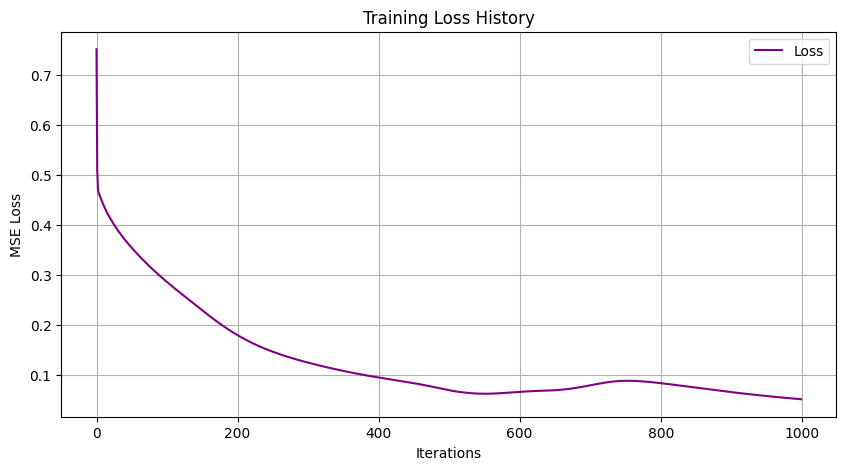

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(np.array(history_loss), label='Loss', color='purple')
plt.title('Training Loss History')
plt.xlabel('Iterations')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

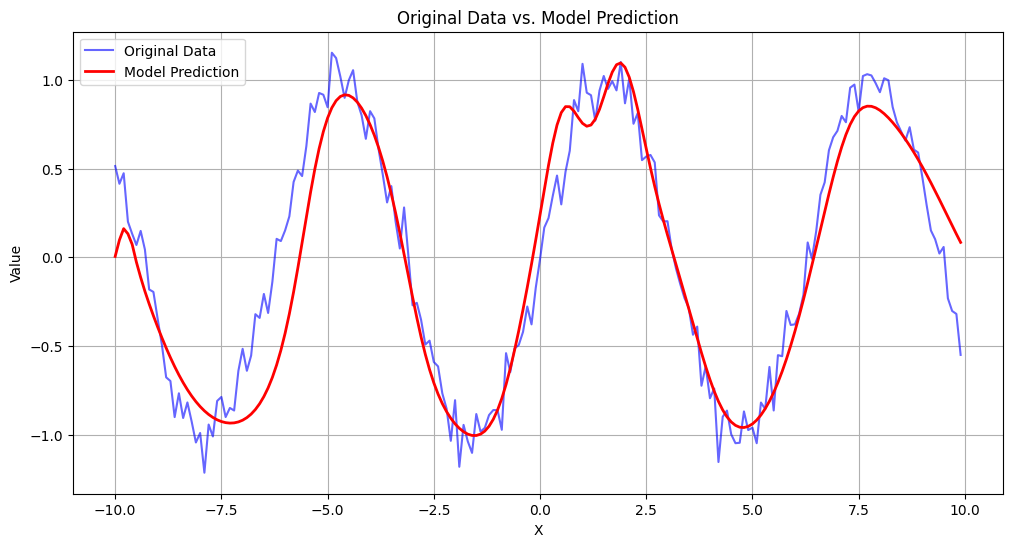

In [19]:
predictions, _ = forward(X)
plt.figure(figsize=(12, 6))
plt.plot(X, y, label='Original Data', color='blue', alpha=0.6)
plt.plot(X, predictions, label='Model Prediction', color='red', linewidth=2)
plt.title('Original Data vs. Model Prediction')
plt.xlabel('X')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()